# Predictive Model - Hotel Data set
Data set is from a previous Kaggle Challenge 
https://www.kaggle.com/jessemostipak/hotel-booking-demand

In [118]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas_profiling
from pandas_profiling import ProfileReport

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning


from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve
# from category_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance # For interpretability


In [119]:
!pip install pandas-profiling[notebook,html]

In [120]:
DATA_SET = 'hotel_bookings.csv'
# DATA_PATH = 'C:\Users\bhavertz\OneDrive - alcsolutions.com\Documents\Python Scripts' 
ex = pd.read_csv(DATA_SET)
print(ex.shape)
ex.head()


(119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# Wrangle Function

In [ ]:
def wrangle(filepath):
  

  # read file path and set date as index column 
  df = pd.read_csv(filepath, parse_dates=['reservation_status_date'],index_col = 'reservation_status_date').sort_index()

  # drop rows with many NaN values
  df.drop(columns = ['agent','company','hotel', 'distribution_channel'], inplace = True)

  # # drop all object columns 
  # df.drop(columns = ['arrival_date_month','meal','country','market_segment','reserved_room_type','assigned_room_type','deposit_type','customer_type'], inplace = True)

  # drop rows with high cardinality 
  cols_to_drop = []
  for col in df.select_dtypes('object').columns:
    if df[col].nunique() > 200:
      cols_to_drop.append(col)
  
  df = df.drop(columns =cols_to_drop)


  # drop any outlier
  df = df[(df['adr']<= 1000) & (df['adr']>0)]
 
  

  # target column 
  # we need to create a target vector 
  df['great'] = (df['adr'] < 75).astype(int)
  df.drop(columns = ['adr'],inplace = True)
  

  #Clean binary encoded columns
  # categorical_cols = df.select_dtypes('object').columns

  # binary_cols = [col for col in categorical_cols if df[col].nunique() < 4]

  # Nan Values
  df = df.dropna()


  return df

df = wrangle(DATA_SET)

In [ ]:
print(df.shape)

df.head()

(118898, 28)


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,great
reservation_status_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-10-17,1,300,2015,August,33,13,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,62.8,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,62.8,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,62.8,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,62.8,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,62.8,0,0,Canceled,1


In [ ]:
|  df = df[(df['adr']<= 1000) & (df['adr']>0)]

### Notes about wrangle Function Here




*  Drop High Cardinality Columns 
*  Drop Columns with a constant value 
*  



```
# This is formatted as code
```
### To Do List



1.   More graphs 


*   PLT.plot 
*   List item


2.   List item




# Exploratory Analysis

### Graphs here


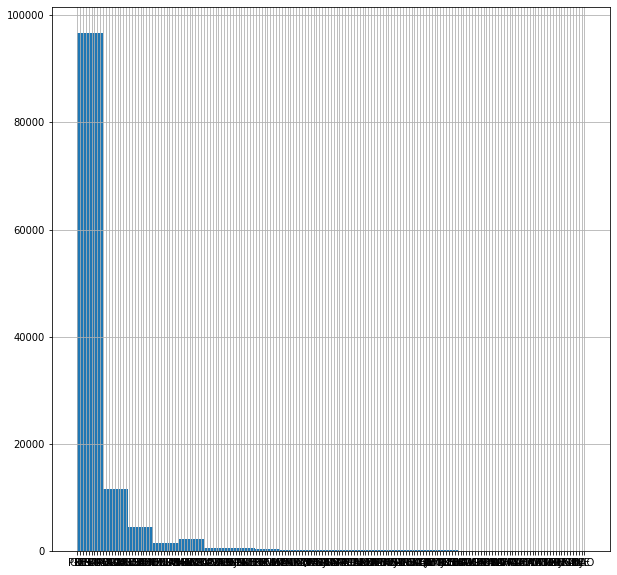

In [ ]:
plt.figure(figsize=(10,10))

# plt.plot(df['deposit_type'])

df['country'].hist(bins = 20)

Text(0.5, 1.0, 'Cardinality')

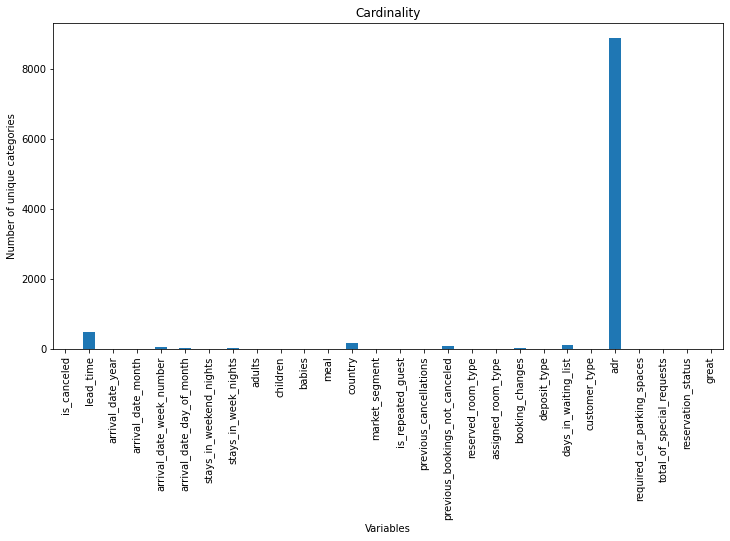

In [ ]:
# we will set the y variable equal to adr (average daily rate)
# here we can see that our data set looks pretty clean and ready to use! 
df.nunique().plot.bar(figsize=(12,6))
plt.ylabel('Number of unique categories')
plt.xlabel('Variables')
plt.title('Cardinality')

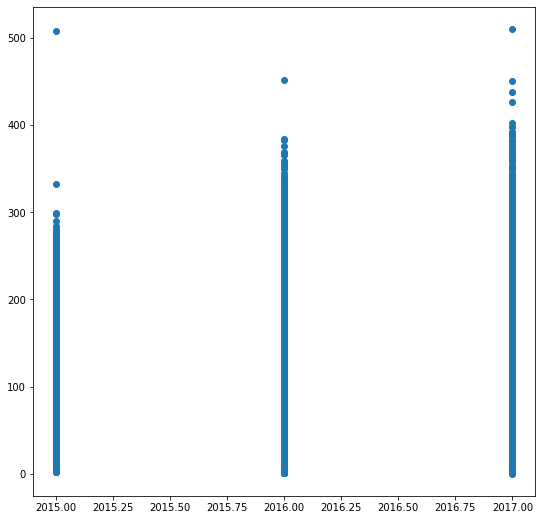

In [ ]:
plt.figure(figsize=(9,9))
plt.scatter(df['arrival_date_year'],df['adr'])

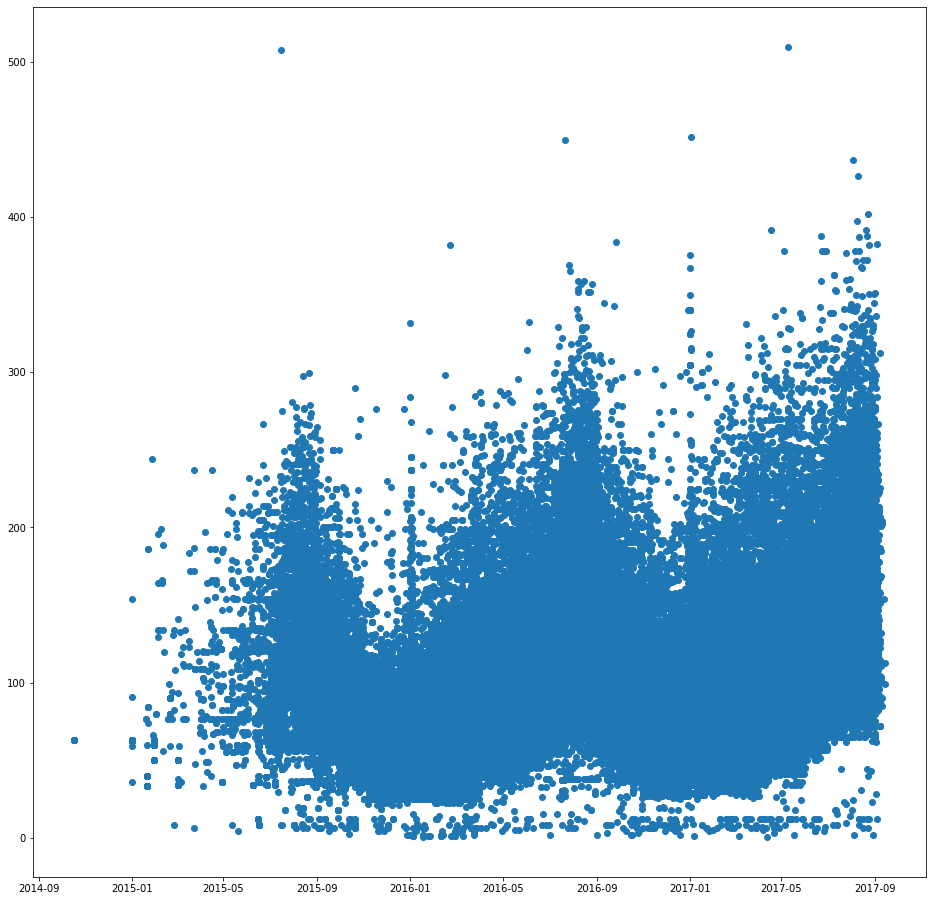

In [ ]:
plt.figure(figsize=(16,16))
plt.scatter(df.index,df['adr'])
# delete the 0's in the graph?

{'boxes': [<matplotlib.lines.Line2D at 0x7f2339f4fd50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f2339d7a190>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2339cfe510>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2339d7a0d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f233c374090>,
  <matplotlib.lines.Line2D at 0x7f2339d9d8d0>]}

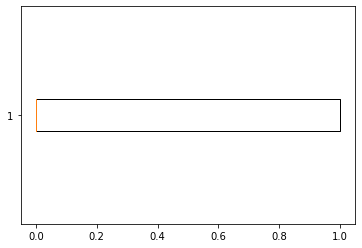

In [ ]:
plt.boxplot(y_train, vert = False)

### Analysis

In [ ]:
df.isnull().sum()
df['country'].value_counts()

PRT    48586
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
CYM        1
KIR        1
AIA        1
PLW        1
MMR        1
Name: country, Length: 177, dtype: int64

In [ ]:
df['customer_type'].value_counts(normalize = True)


Transient          0.750794
Transient-Party    0.210066
Contract           0.034507
Group              0.004633
Name: customer_type, dtype: float64

In [ ]:
df['customer_type'].nunique()

4

In [ ]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,great
count,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000,116958.000000
mean,0.375767,105.376879,2016.161443,27.138109,15.805050,0.937687,2.522974,1.862438,0.104824,0.007866,0.027959,0.086963,0.119795,0.216505,2.347373,103.649070,0.061997,0.571273,0.277638
std,0.484322,106.944356,0.706509,13.561162,8.783049,0.993329,1.885574,0.481129,0.400296,0.097102,0.164855,0.850186,1.432435,0.633569,17.712061,46.646454,0.244426,0.791495,0.447836
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.260000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000
50%,0.000000,71.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000
75%,1.000000,162.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,1.000000
max,1.000000,709.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,4.000000,10.000000,10.000000,1.000000,26.000000,72.000000,18.000000,391.000000,510.000000,8.000000,5.000000,1.000000


In [ ]:
df['reservation_status'].value_counts()

Check-Out    74745
Canceled     42950
No-Show       1203
Name: reservation_status, dtype: int64

In [ ]:
# df['adr'].mean()


In [ ]:
# df['adr'].describe()

In [ ]:
# # lets say anything below 90% is considered a good price
# df['great'] = (df['adr'] <= 95).astype(int)
# df['great']

In [ ]:
df.isnull().sum()

In [ ]:
# df['distribution_channel'].value_counts().sum()

In [ ]:
df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,reservation_status,great
reservation_status_date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-10-17,1,300,2015,August,33,13,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1


In [ ]:
# df['country'].value_counts()
df.info()

In [ ]:
df.dtypes == object

In [ ]:
# the goal of this is to find the probability if someone booking the hotel at a certain location 
df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,reservation_status,great
reservation_status_date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-10-17,1,300,2015,August,33,13,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1


In [ ]:
# df['adr'].mean()
# df['adr'].median()
# # df['adr'].mode()
# X_train['adr'].median()

# Split Data

In [ ]:
target = 'great'
y = df[target]
X = df.drop(target, axis = 1)

 # df['great'] = (df['adr'] <= 92).astype(int)

In [ ]:
# what do I want my mask to be??
# find the date range in the index val 
# date ranges from 2014 -2017

train_mask = X.index.year < 2016

# Training before 2016
X_train, y_train = X.loc[train_mask], y.loc[train_mask]

# Training during 2016
validation_mask = X.index.year == 2016
X_val, y_val = X.loc[validation_mask], y.loc[validation_mask]

# Test after 2016
test_mask = X.index.year >2016
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

In [ ]:
y_train.mean()

0.45892095769104624

In [ ]:
baseline_accuracy = y_train.value_counts(normalize=True).max()*100

print('Baseline Accuracy is', baseline_accuracy)

Baseline Accuracy is 54.10790423089538


In [ ]:
y.shape
y_pred_baseline = [y.mean()]*y.shape[0]

In [ ]:
# from sklearn.linear_model import LinearRegression
# model_lr = LinearRegression()
# model_lr.fit(X, y)
# # here
# y_pred = model_lr.predict(X)
# model_lr.coef_

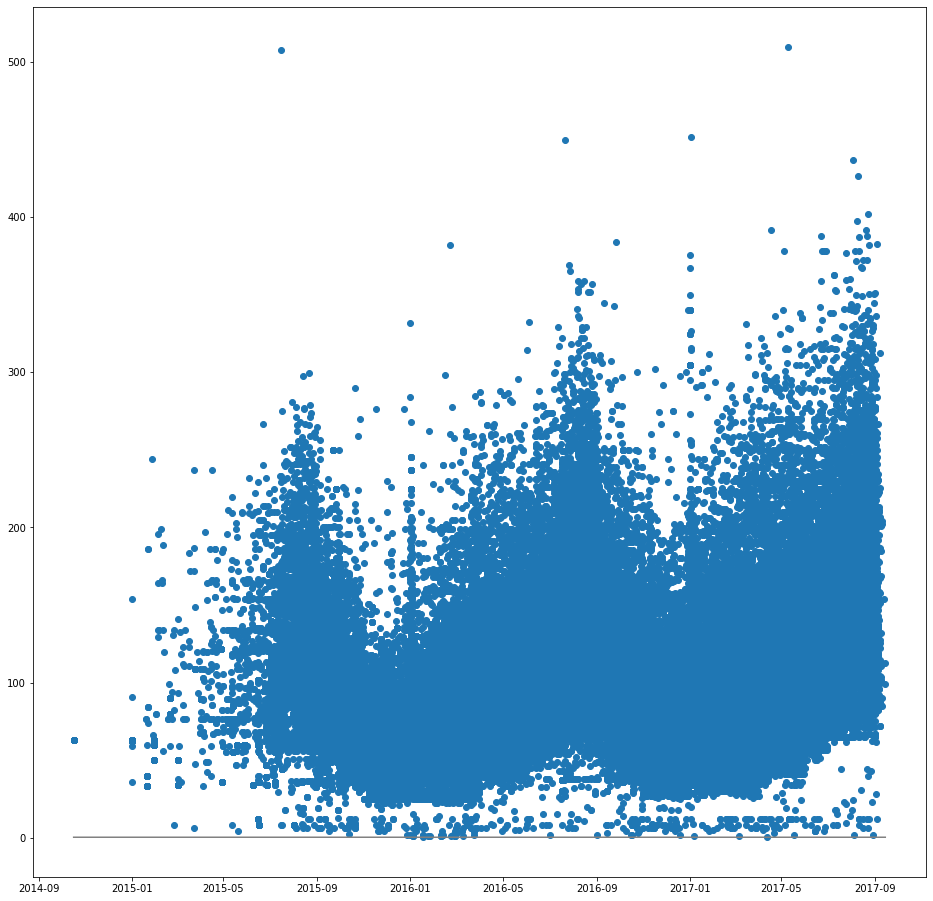

In [ ]:
plt.figure(figsize=(16,16))
plt.scatter(df.index,df['adr'])
# plt.plot(df.index, df['adr'].mean(),color = 'red')
plt.plot(df.index, y_pred_baseline, color = 'grey', label = 'Baseline Model')
# plt.line(df.index, slope, color = 'red', label = "Linear Line")

In [ ]:
from scipy import stats
# slope, intercept, r_value, p_value, std_err = stats.linregress(df.index, df['adr'])

from sklearn import linear_model
reg = linear_model.LinearRegression()

slope = df['adr'].mean()
slope
# need to find intercept 



103.64906983703007

In [ ]:
X_test

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,reservation_status
reservation_status_date,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1,138,2017,January,1,2,1,3,3,0.0,0,HB,ITA,Online TA,0,0,0,D,D,0,No Deposit,0,Transient,0,3,Canceled
2017-01-01,1,130,2017,May,19,11,1,3,2,0.0,0,BB,AUT,Online TA,0,0,0,A,A,0,No Deposit,0,Transient,0,0,Canceled
2017-01-01,1,121,2017,April,17,28,1,2,2,0.0,0,HB,HUN,Online TA,0,0,0,D,D,0,No Deposit,0,Transient,0,0,Canceled
2017-01-01,1,106,2017,April,15,13,0,2,2,0.0,0,SC,ESP,Online TA,0,0,0,A,A,0,No Deposit,0,Transient,0,0,Canceled
2017-01-01,1,106,2017,April,15,13,0,2,2,0.0,0,SC,ESP,Online TA,0,0,0,A,A,0,No Deposit,0,Transient,0,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-10,0,169,2017,August,35,30,2,9,2,0.0,0,BB,IRL,Direct,0,0,0,E,E,0,No Deposit,0,Transient-Party,0,1,Check-Out
2017-09-10,0,269,2017,August,34,24,4,13,2,0.0,0,BB,GBR,Offline TA/TO,0,0,0,D,D,0,No Deposit,0,Contract,0,2,Check-Out
2017-09-12,0,204,2017,August,35,29,4,10,2,0.0,0,BB,IRL,Direct,0,0,0,E,E,0,No Deposit,0,Transient,0,3,Check-Out


# Establish Basline

In [ ]:
print('Baseline Accuracy',y_train.value_counts(normalize = True).max()) 

Baseline Accuracy 0.5410790423089538


In [ ]:
y_train.mean()

0.45892095769104624

In [ ]:
df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,great
reservation_status_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-10-17,1,300,2015,August,33,13,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,62.8,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,62.8,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,62.8,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,62.8,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,62.8,0,0,Canceled,1


# Build Model

In [ ]:
# we need to do some ohe
# with building my model, I want to focus on a lot of tuning, hyperparameters, and howo to upload the file into github. 
# different ways tp build models
#   -Logistic Regression
#   -

### Logistic Regression

In [ ]:
# dont forget about the ADR column
# logistic regression most likel does not work 

model_lr_test = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(strategy='mean'),
    LogisticRegression()
)

model_lr_test.fit(X_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Check Metrics for Logistic Regression

In [ ]:
# print("Training Accuracy:",model_lr_test.score(X_test, y_test))
# print("Validation Accuracy:",model_lr_test.score(X_test, y_test))

### Decision Tree

In [ ]:
# model_dt = make_pipeline(
#     OrdinalEncoder(),
#     SimpleImputer(),
#     DecisionTreeClassifier()
# )

# cv_scores_dt = cross_val_score(model_dt, X_train, y_train, cv=10, n_jobs=-1)

### Everything Else

In [ ]:
ohe = OneHotEncoder()
imp = SimpleImputer()
clf = LogisticRegression()

In [ ]:
ct = make_column_transformer(
    (ohe, ['arrival_date_month','meal','country','market_segment',
    'distribution_channel','reserved_room_type','deposit_type','customer_type',
    'reservation_status']),
    


    
)

In [ ]:
pipe = make_pipeline(
    ct,
    clf
)

In [ ]:
df.isnull().sum()

In [ ]:
# pipe.fit(X_train, y_train)
# df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,reservation_status,great
reservation_status_date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-10-17,1,300,2015,August,33,13,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1


In [ ]:
df.info()

In [ ]:
X_train.info()

In [ ]:
y_train.value_counts(normalize = True)

0    0.541079
1    0.458921
Name: great, dtype: float64

In [ ]:
# model_lr = make_pipeline(
#     OneHotEncoder()
# )

# model_lr.fit(X_train, y_train)
print(y_train.shape)
print(X_train.shape)

(24392,)
(24392, 27)


In [ ]:
# y_train.isnull().sum()
# df.head()
# # df['reserved_room_type'].value_counts()
# df.info()
# df.isnull().sum()
# df.dropna()

### Random Forest

In [ ]:
model_rf =  make_pipeline(

    OneHotEncoder(handle_unknown='ignore'),
    # SimpleImputer(strategy = 'constant'),
    
    RandomForestClassifier()
)

# ,handle_unknown = 'ignore'  sparse = True
model_rf.fit(X_train, y_train);

In [ ]:
model_rf.predict([X_test.iloc[0]])

array([0])

### Logistic Regression

In [ ]:
model_lr = make_pipeline(
    OneHotEncoder(handle_unknown='ignore',sparse = True),
    SimpleImputer(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(df.shape)
df.head()

(116958, 27)


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,reservation_status,great
reservation_status_date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-10-17,1,300,2015,August,33,13,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1
2014-10-17,1,286,2015,July,31,30,0,2,2,0.0,0,BB,PRT,Groups,1,1,0,A,A,0,No Deposit,0,Transient-Party,0,0,Canceled,1


In [ ]:
# new column for predictive model here
Xnew = [[1,	138,	2017,	1,	2,	1,	3,	3,	0.0,	0	,0,	0,	0,	0,	0,	164.05,	0,	3,	'Canceled']]
Xnew;
new_line = [[1,286,2016,'August',31,13,1,2,2,0,0,'BB','PRT','Groups',1,0,0,'A','A',0,'Deposit',0,'Transient-Party',0,0,'Canceled',1]]

In [ ]:
model_rf.predict(new_line)

array([1])

In [ ]:
print("This represents the probabilty that a customer will pay for a room at this location",
      model_rf.predict_proba(new_line)[0])
model_rf.predict_proba(new_line)


This represents the probabilty that a customer will pay for a room at this location [0.35 0.65]


array([[0.35, 0.65]])

In [ ]:
X_test.iloc[0]

is_canceled                                1
lead_time                                138
arrival_date_year                       2017
arrival_date_month                   January
arrival_date_week_number                   1
arrival_date_day_of_month                  2
stays_in_weekend_nights                    1
stays_in_week_nights                       3
adults                                     3
children                                   0
babies                                     0
meal                                      HB
country                                  ITA
market_segment                     Online TA
is_repeated_guest                          0
previous_cancellations                     0
previous_bookings_not_canceled             0
reserved_room_type                         D
assigned_room_type                         D
booking_changes                            0
deposit_type                      No Deposit
days_in_waiting_list                       0
customer_t

In [ ]:
X_test.head()

# Check for Leakage

# ROC Curve 

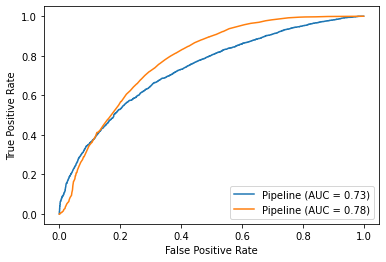

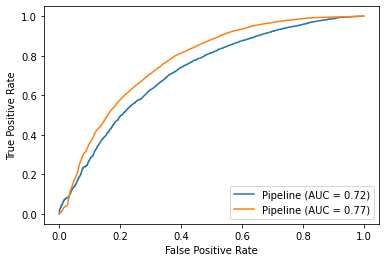

In [ ]:
lr = plot_roc_curve(model_lr, X_test, y_test)

rf = plot_roc_curve(model_rf,
                   X_test,
                   y_test,
                   ax=lr.ax_)

lr = plot_roc_curve(model_lr, X_val, y_val)

rf = plot_roc_curve(model_rf,
                   X_val,
                   y_val,
                   ax=lr.ax_)

In [ ]:
# Get predicted probabilities from model
y_pred_prob = model_rf.predict_proba(X_val)[:, -1]


# Input true labels and probability predictions
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Put data into dictionary
data = {'false_pos_rate': fpr,
        'true_pos_rate': tpr,
        'thresholds': thresholds}

pd.DataFrame(data)

,false_pos_rate,true_pos_rate,thresholds
0,0.000000,0.000000,2.000
1,0.000791,0.001328,1.000
2,0.002613,0.006388,0.990
3,0.005657,0.006704,0.970
4,0.005657,0.007843,0.960
...,...,...,...
1397,0.996213,0.999937,0.026
1398,0.996285,0.999937,0.025
1399,0.998274,1.000000,0.020
1400,0.999569,1.000000,0.010


Logistic Regression
              precision    recall  f1-score   support

           0       0.84      0.68      0.75     41718
           1       0.44      0.65      0.52     15811

    accuracy                           0.67     57529
   macro avg       0.64      0.67      0.64     57529
weighted avg       0.73      0.67      0.69     57529



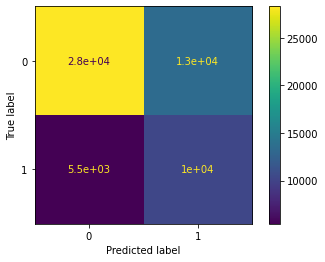

In [ ]:
print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))

plot_confusion_matrix(model_lr, X_val, y_val);

Random Forest
              precision    recall  f1-score   support

           0       0.85      0.76      0.80     41718
           1       0.50      0.64      0.56     15811

    accuracy                           0.72     57529
   macro avg       0.67      0.70      0.68     57529
weighted avg       0.75      0.72      0.73     57529



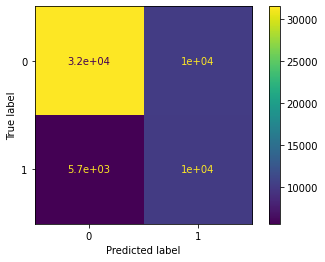

In [ ]:
print('Random Forest')
print(classification_report(y_val, model_rf.predict(X_val))) # VALIDATION DATA
plot_confusion_matrix(model_rf, X_val, y_val);

# Tuning / Communication

In [ ]:
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_train.columns
feature_names

feat_imp = pd.Series(data=importances, index=feature_names).sort_values()

# feat_imp.tail(10).plot(kind='barh');

ValueError: ignored

In [ ]:
print(importances.shape)
print(feature_names.shape)

(818,)
(26,)


In [ ]:
# importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
# feature_names = X_train.columns

# feat_imp = pd.Series(data=importances, index=feature_names).sort_values()

# feat_imp.tail(10).plot(kind='barh');

ValueError: ignored

In [ ]:
col = 'quantity'

model_w_col = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=25, random_state=42, n_jobs=-1)
)

model_w_col.fit(X_train, y_train)

print('Training Accuracy with column included:', model_w_col.score(X_val, y_val))

In [ ]:
perm_imp = permutation_importance(model_xgb, 
                                  X_val, 
                                  y_val, 
                                  n_repeats=5, 
                                  n_jobs=-1, 
                                  random_state=42)

In [ ]:
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']}

importances = pd.DataFrame(data, index=X_val.columns).sort_values(by='imp_mean')

importances.head()

,imp_mean,imp_std
arrival_date_year,-0.000059,0.000214
previous_cancellations,-0.000007,0.000024
reservation_status,0.000000,0.000000
booking_changes,0.000000,0.000000
babies,0.000000,0.000000


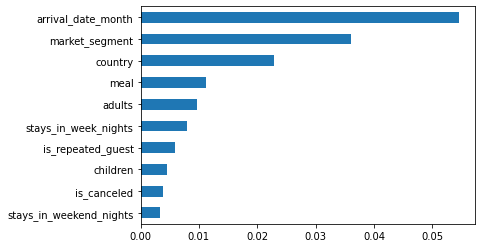

In [ ]:
importances['imp_mean'].tail(10).plot(kind='barh')

### Permutation Importance 

In [ ]:
# do it again and randomize the column of interest
# Step 1: Choose a Feature
col = 'arrival_date_month'

# Step 2: Train the model with all features
model_w_col = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=25, random_state=42, n_jobs=-1)
)

model_w_col.fit(X_train, y_train);

In [ ]:
# Step 3: Evaluate the Model using VALIDATION DATA'

print('XGBoost Validation Accuracy', model_xgb.score(X_val, y_val))

XGBoost Validation Accuracy 0.8160753706826123


In [ ]:
# Step 4: In our VALIDATION data, permute the feature we're evaluating
X_val_perm = X_val.copy()
X_val_perm[col] = np.random.permutation(X_val_perm[col])

In [ ]:
# pandas approach to permutation
df['arrival_date_month'] = df['arrival_date_month'].sample(1)

In [ ]:
#Step 5: Calculate our error metric with the permuted data
print('XGBoost Validation Accuracy with "quantity" permuted', model_xgb.score(X_val_perm, y_val))

XGBoost Validation Accuracy with "quantity" permuted 0.761181317248692


In [ ]:
0.8160753706826123-0.761181317248692

0.05489405343392029